# PDI - Rebalancing data for July 2022

## Setting

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
from defillama import DefiLlama
llama = DefiLlama()

In [4]:
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Token inclusion criteria

1. **Project and token characteristics** 
    1. The project must have a listing on Defi Llama
    1. The project’s token should have been listed on CoinGecko with pricing data at least 1 year prior to the date of inclusion in the index. 
    1. The project should have a token that is native to Ethereum L1 or L2. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project. 
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible. 
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.

1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange.
    1. The token should have at least $5mm of total liquidity at Uniswap v2, Uniswap v3, Sushiswap, Balancer, Bancor. 
    1. The token must have shown consistent DeFi liquidity on Ethereum.

1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available. Alternatively, the protocol must have been operating long enough to create a consensus about its safety in the decentralised finance community.

### Tokens list

#### DefiLlama

In [6]:
protocols = llama.get_all_protocols()

In [7]:
top_defi_tokens = {} 
for pr in protocols[:1000]:
    if 'Ethereum' in pr['chains'] and pr['address'] and pr['address']!='-' and pr['symbol'] != '-':
        symbol = ''.join(c for c in pr['symbol'] if c.isalnum()).upper()
        top_defi_tokens[symbol] = {
            'symbol': symbol, 
            'address': pr['address'].lower()
        }

In [8]:
top_defi_tokens['XSUSHI'] = {
    'symbol': 'XSUSHI',
    'address': "0x8798249c2e607446efb7ad49ec89dd1865ff4272",
}

#### CoinGecko

##### Tokens addresses

In [9]:
coins_list = pd.DataFrame(cg.get_coins_list(include_platform=True))

In [10]:
tokens = {} 
tokens_by_addr = {}
for index, coin in coins_list.iterrows():
    if len(coin['platforms']) >= 1 and 'ethereum' in list(coin['platforms'].keys()):
        symbol = ''.join(c for c in coin['symbol'] if c.isalnum()).upper()
        address = coin['platforms']['ethereum'].lower()
        token = {
            'symbol': symbol,
            'address': address 
        }
        tokens[symbol] = token
        tokens_by_addr[address] = token

In [11]:
tokens['USDC'], tokens['WETH']

({'symbol': 'USDC', 'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'},
 {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'})

In [12]:
tokens['BNT']

{'symbol': 'BNT', 'address': '0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c'}

In [13]:
# These token's addresses cant be found in the coingecko list of eth addresses
exclude_symbols = []
for symb, token in top_defi_tokens.items():
    if token['address'] not in tokens_by_addr.keys():
        print(token)
        exclude_symbols.append(token['symbol'])

{'symbol': 'MULTI', 'address': '0x9fb9a33956351cf4fa040f65a13b835a3c8764e3'}
{'symbol': 'IB', 'address': 'fantom:0x00a35fd824c717879bf370e70ac6868b95870dfb'}
{'symbol': 'COW', 'address': 'heco:0x80861a817106665bca173db6ac2ab628a738c737'}
{'symbol': 'PINKSALE', 'address': 'bsc:0x602ba546a7b06e0fc7f58fd27eb6996ecc824689'}
{'symbol': 'ABR', 'address': 'celo:0x6e512bfc33be36f2666754e996ff103ad1680cc9'}
{'symbol': 'FLAG', 'address': '0x57dd84042ec9507963016596a34edad42f7e4cce '}
{'symbol': 'HEC', 'address': 'fantom:0x5c4fdfc5233f935f20d2adba572f770c2e377ab0'}
{'symbol': 'RSR', 'address': '0x8762db106b2c2a0bccb3a80d1ed41273552616e8'}
{'symbol': 'FHM', 'address': '0xfa1fbb8ef55a4855e5688c0ee13ac3f202486286'}
{'symbol': 'SOLV', 'address': '0x256f2d67e52fe834726d2ddcd8413654f5eb8b53'}
{'symbol': 'SGT', 'address': '0x84810bcf08744d5862b8181f12d17bfd57d3b078'}
{'symbol': 'GEAR', 'address': '0xba3335588d9403515223f109edc4eb7269a9ab5d'}
{'symbol': 'SWPR', 'address': 'arbitrum:0xde903e2712288a1da829

In [14]:
for symb in exclude_symbols:
    del top_defi_tokens[symb]

In [15]:
# KEEP has this address in defillama, but etherscan says this address belongs to tBTC now
# for token in top_defi_tokens.values():
#     if token['address'] == "0x8daebade922df735c38c80c7ebd708af50815faa":
#         print(token)
# del top_defi_tokens['KEEP']

##### Market data

In [16]:
cg_tokens_data = cg.get_coins_markets(vs_currency='USD', order='market_cap_desc')
for i in range(2, 20):
    cg_tokens_data.extend(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', page=i))
    
cg_tokens_data = pd.DataFrame.from_records(cg_tokens_data)

In [17]:
tokens_market_data = cg_tokens_data.set_index(cg_tokens_data['symbol'].str.upper())

In [18]:
duplicated = tokens_market_data.index[tokens_market_data.index.duplicated(keep='first')]
tokens_market_data = tokens_market_data.drop(index=duplicated)

In [19]:
tokens_market_data

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
BTC,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,19562.500000,376053830104,1,4.137719e+11,2.062821e+10,20412.000000,...,2.100000e+07,2.100000e+07,69045.000000,-71.44490,2021-11-10T14:24:11.849Z,67.810000,28975.49849,2013-07-06T00:00:00.000Z,None,2022-07-05T11:53:53.923Z
ETH,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,1115.230000,134551087696,2,NaN,1.501792e+10,1166.990000,...,1.195625e+08,NaN,4878.260000,-76.89309,2021-11-10T14:24:19.604Z,0.432979,260239.53471,2015-10-20T00:00:00.000Z,"{'times': 75.22251583596311, 'currency': 'btc'...",2022-07-05T11:54:28.406Z
USDT,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.002000,66046063194,3,NaN,5.392983e+10,1.005000,...,6.604354e+10,NaN,1.320000,-24.51969,2018-07-24T00:00:00.000Z,0.572521,74.43490,2015-03-02T00:00:00.000Z,None,2022-07-05T11:51:27.581Z
USDC,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,0.997805,55985612478,4,NaN,5.135360e+09,1.009000,...,5.583756e+10,NaN,1.170000,-14.57544,2019-05-08T00:40:28.300Z,0.891848,12.32622,2021-05-19T13:14:05.611Z,None,2022-07-05T11:54:41.472Z
BNB,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,226.990000,37300506325,5,3.772080e+10,1.246435e+09,236.030000,...,1.632770e+08,1.651168e+08,686.310000,-66.72673,2021-05-10T07:24:17.097Z,0.039818,573405.36577,2017-10-19T00:00:00.000Z,None,2022-07-05T11:55:09.455Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FNT,falcon-token,fnt,Falcon Project,https://assets.coingecko.com/coins/images/1157...,0.000083,1010817,1894,NaN,2.110040e+03,0.000085,...,8.760000e+10,NaN,0.006536,-98.72881,2021-02-19T18:29:18.280Z,0.000047,78.28899,2020-11-06T17:21:16.092Z,None,2022-07-05T05:22:59.695Z
CPC,cpchain,cpc,CPChain,https://assets.coingecko.com/coins/images/2760...,0.002482,1009779,1896,NaN,8.193100e+04,0.002641,...,1.000000e+09,NaN,0.571369,-99.56583,2018-02-10T00:00:00.000Z,0.000172,1345.40195,2020-01-27T12:32:29.023Z,"{'times': -0.9779372002766259, 'currency': 'et...",2022-07-05T11:50:05.764Z
IDEA,ideaology,idea,Ideaology,https://assets.coingecko.com/coins/images/1393...,0.030551,1009189,1897,1.529074e+07,3.470670e+05,0.032415,...,5.000000e+08,5.000000e+08,0.963831,-96.83062,2021-05-10T15:31:47.873Z,0.029823,2.42873,2022-07-03T09:57:27.458Z,None,2022-07-05T11:53:49.045Z


### Liquidity check

In [20]:
api_urls = {
    'univ2': "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2",
    'univ3': "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3",
    'sushi': "https://api.thegraph.com/subgraphs/name/zippoxer/sushiswap-subgraph-fork",
    'balancer': "https://api.thegraph.com/subgraphs/name/balancer-labs/balancer",
    'bancorv2': "https://api-v2.bancor.network/tokens",
    'bancorv3': "https://api-v3.bancor.network/pools",
} 

In [21]:
def univ2_get_liquidities(tokens_ids):
    query = """
        query tokens ($tokens_ids: [ID!]!) {
            tokens (first:1000, where: {id_in: $tokens_ids}){
                id
                symbol
                totalLiquidity
            }
        }
    """
    url = api_urls['univ2']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    tokens = response.json()['data']['tokens']
    
    liqs = {}
    for token in tokens:
        liqs[token['symbol']] = float(token['totalLiquidity'])
        
    return liqs
    

In [22]:
def univ3_get_liquidities(tokens_ids):
    query = """
        query tokens ($tokens_ids: [ID!]!) {
            tokens (first:1000, where: {id_in: $tokens_ids}){
                id
                symbol
                totalValueLockedUSD
            }
        }
    """
    url = api_urls['univ3']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    tokens = response.json()['data']['tokens']
    
    liqs = {}
    for token in tokens:
        liqs[token['symbol']] = float(token['totalValueLockedUSD'])
        
    return liqs
    

In [23]:
def sushi_get_liquidities(tokens_ids):
    query = """
        query tokens ($tokens_ids: [ID!]!) {
            tokens (first:1000, where: {id_in: $tokens_ids}){
                id
                symbol
                totalLiquidity
            }
        }
    """
    url = api_urls['sushi']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    tokens = response.json()['data']['tokens']
    
    liqs = {}
    for token in tokens:
        liqs[token['symbol']] = float(token['totalLiquidity'])
        
    return liqs
    

In [24]:
def bancorv2_get_liquidities(tokens_ids):
    url = api_urls['bancorv2'] 
    response = requests.get(url)
    tokens = response.json()['data']
    
    liqs = {}
    for token in tokens:
        if token['dlt_id'].lower() in tokens_ids:
            liqs[token['symbol']] = float(token['liquidity']['usd'])
            
    return liqs
            

In [25]:
def bancorv3_get_liquidities(tokens_ids):
    url = api_urls['bancorv3'] 
    response = requests.get(url)
    pools = response.json()['data']
    
    liqs = {}
    for pool in pools:
        if pool['poolDltId'].lower() in tokens_ids:
            liqs[pool['name']] = liqs.get(pool['name'], 0) + float(pool['liquidity']['usd'])
            
    return liqs
            

In [26]:
def balancer_get_liquidities(tokens_ids):
    query = """
        query pools {
            pools (
                where: {
                  liquidity_gt: 1000000,
                  
                }
            ){
                tokens {
                  address
                  symbol
                  balance
                }
          }
        }
    """
    url = api_urls['balancer']
    
    response = requests.post(url, json={'query': query})
    pools = response.json()['data']['pools']
    
    liqs = {}
    for pool in pools:
        for token in pool['tokens']:
            symb = token['symbol']
            if symb not in tokens_market_data.index or token['address'].lower() not in tokens_ids:
                continue
            
            liqs[symb] = liqs.get(symb, 0) + float(token['balance']) * tokens_market_data.loc[symb]['current_price']
        
    return liqs
    

In [27]:
tokens_ids = [token['address'] for symb, token in top_defi_tokens.items()]

In [28]:
query_functions = {
    'univ2': univ2_get_liquidities,
    'univ3': univ3_get_liquidities, 
    'sushi': sushi_get_liquidities, 
    'bancorv2': bancorv2_get_liquidities,
    'bancorv3': bancorv3_get_liquidities,
    'balancer': balancer_get_liquidities, 
}

In [29]:
liqs_dict = {}
for dex, func in query_functions.items():
    liqs_dict[dex] = func(tokens_ids)

In [30]:
liquidities = pd.DataFrame.from_dict(liqs_dict)

In [31]:
liquidities['sum'] = liquidities.sum(axis=1)
liquidities.sort_values('sum', ascending=False)

,univ2,univ3,sushi,bancorv2,bancorv3,balancer,sum
,NaN,NaN,6.210012e+22,NaN,NaN,NaN,6.210012e+22
BAO,1.519289e+09,0.000000,2.577410e+09,NaN,NaN,NaN,4.096699e+09
SPELL,4.022343e+03,237368.197768,8.290598e+08,2193.99911,NaN,NaN,8.293034e+08
LFT,6.308365e+08,0.000000,NaN,NaN,NaN,NaN,6.308365e+08
RISE,6.158919e+08,NaN,NaN,NaN,NaN,NaN,6.158919e+08
...,...,...,...,...,...,...,...
UNFI,4.360053e-11,NaN,NaN,NaN,NaN,NaN,4.360053e-11
ONES,3.747800e-14,NaN,NaN,NaN,NaN,NaN,3.747800e-14
VIRTUE,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000e+00
HND,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000e+00


In [32]:
liq_check = (liquidities['sum'] > 5e6).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [33]:
lq_passed = tokens_market_data[
    tokens_market_data.index.isin(liq_check_passed.index)
]

In [34]:
lq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
WBTC,wrapped-bitcoin,wbtc,Wrapped Bitcoin,https://assets.coingecko.com/coins/images/7598...,19511.830000,5131474480,16,5.131474e+09,2.826174e+08,20418.000000,...,2.603888e+05,2.603888e+05,70643.000000,-72.05486,2021-11-10T14:40:19.650Z,3.139170e+03,5.288724e+02,2019-04-02T00:00:00.000Z,None,2022-07-05T11:55:00.327Z
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.150000,2377994967,28,5.209308e+09,1.084242e+08,5.420000,...,1.000000e+09,1.000000e+09,44.920000,-88.36759,2021-05-03T05:25:04.822Z,1.030000e+00,4.072025e+02,2020-09-17T01:20:38.214Z,None,2022-07-05T11:55:11.340Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,59.340000,832461399,54,9.568246e+08,1.583461e+08,63.850000,...,1.600000e+07,1.600000e+07,661.690000,-90.91587,2021-05-18T21:19:59.514Z,2.602000e+01,1.309821e+02,2020-11-05T09:20:11.928Z,None,2022-07-05T11:54:42.018Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,918.190000,830219684,55,9.262617e+08,7.331937e+07,958.890000,...,9.776310e+05,1.005577e+06,6292.310000,-85.31268,2021-05-03T21:54:29.333Z,1.683600e+02,4.489342e+02,2020-03-16T20:52:36.527Z,None,2022-07-05T11:54:52.346Z
AMP,amp-token,amp,Amp,https://assets.coingecko.com/coins/images/1240...,0.009085,438111757,94,9.053979e+08,6.635825e+06,0.009464,...,9.944412e+10,9.922516e+10,0.120813,-92.42663,2021-06-16T16:03:41.147Z,2.505010e-03,2.652510e+02,2020-11-04T13:18:12.191Z,None,2022-07-05T11:55:09.456Z
FEI,fei-usd,fei,Fei USD,https://assets.coingecko.com/coins/images/1457...,1.001000,360361406,103,3.607159e+08,8.304720e+05,1.016000,...,3.604219e+08,3.604219e+08,1.110000,-9.74640,2021-05-19T17:09:49.508Z,6.694350e-01,4.938840e+01,2021-04-18T03:44:09.238Z,None,2022-07-05T11:54:56.553Z
FXS,frax-share,fxs,Frax Share,https://assets.coingecko.com/coins/images/1342...,4.880000,349118514,105,4.903420e+08,4.997726e+06,4.950000,...,9.982298e+07,9.982298e+07,42.800000,-88.51103,2022-01-12T15:22:27.465Z,1.500000e+00,2.271277e+02,2021-06-25T16:50:51.447Z,None,2022-07-05T11:54:53.433Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,46.980000,323109442,112,4.712739e+08,9.652406e+07,50.330000,...,1.000000e+07,1.000000e+07,910.540000,-94.80740,2021-05-12T02:29:08.794Z,2.641000e+01,7.902481e+01,2022-06-18T20:54:18.261Z,None,2022-07-05T11:54:40.402Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,0.597840,281057215,121,6.021948e+08,3.439690e+07,0.647075,...,1.000000e+09,1.000000e+09,7.300000,-91.72896,2021-08-20T08:35:20.158Z,4.061500e-01,4.871939e+01,2022-06-18T20:55:12.035Z,None,2022-07-05T11:55:11.143Z


### Non quantative checks

In [35]:
exclude_list = [
    {
        'symbol': 'WBTC',
        'reason': 'Criteria 1.C'
    },
    {
        'symbol': 'XSUSHI',
        'reason': 'Duplicates SUSHI'
    },
    {
        'symbol': 'ERN',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'NFTX',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'FXS',
        'reason': 'Criteria 1.G'
    },
    {
        'symbol': 'RGT',
        'reason': 'Deprecated asset'
    },
    {
        'symbol': 'SUPER',
        'reason': 'Not DeFi'
    },
    {
        'symbol': 'BOND',
        'reason': 'Criteria 1.I'
    }
]
exclude_symbols = [token['symbol'] for token in exclude_list]

In [36]:
nq_passed = lq_passed[
    ~lq_passed.index.isin(exclude_symbols)
]

In [37]:
nq_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.150000,2377994967,28,5.209308e+09,1.084242e+08,5.420000,...,1.000000e+09,1.000000e+09,44.920000,-88.36759,2021-05-03T05:25:04.822Z,1.030000e+00,4.072025e+02,2020-09-17T01:20:38.214Z,None,2022-07-05T11:55:11.340Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,59.340000,832461399,54,9.568246e+08,1.583461e+08,63.850000,...,1.600000e+07,1.600000e+07,661.690000,-90.91587,2021-05-18T21:19:59.514Z,2.602000e+01,1.309821e+02,2020-11-05T09:20:11.928Z,None,2022-07-05T11:54:42.018Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,918.190000,830219684,55,9.262617e+08,7.331937e+07,958.890000,...,9.776310e+05,1.005577e+06,6292.310000,-85.31268,2021-05-03T21:54:29.333Z,1.683600e+02,4.489342e+02,2020-03-16T20:52:36.527Z,None,2022-07-05T11:54:52.346Z
AMP,amp-token,amp,Amp,https://assets.coingecko.com/coins/images/1240...,0.009085,438111757,94,9.053979e+08,6.635825e+06,0.009464,...,9.944412e+10,9.922516e+10,0.120813,-92.42663,2021-06-16T16:03:41.147Z,2.505010e-03,2.652510e+02,2020-11-04T13:18:12.191Z,None,2022-07-05T11:55:09.456Z
FEI,fei-usd,fei,Fei USD,https://assets.coingecko.com/coins/images/1457...,1.001000,360361406,103,3.607159e+08,8.304720e+05,1.016000,...,3.604219e+08,3.604219e+08,1.110000,-9.74640,2021-05-19T17:09:49.508Z,6.694350e-01,4.938840e+01,2021-04-18T03:44:09.238Z,None,2022-07-05T11:54:56.553Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,46.980000,323109442,112,4.712739e+08,9.652406e+07,50.330000,...,1.000000e+07,1.000000e+07,910.540000,-94.80740,2021-05-12T02:29:08.794Z,2.641000e+01,7.902481e+01,2022-06-18T20:54:18.261Z,None,2022-07-05T11:54:40.402Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,0.597840,281057215,121,6.021948e+08,3.439690e+07,0.647075,...,1.000000e+09,1.000000e+09,7.300000,-91.72896,2021-08-20T08:35:20.158Z,4.061500e-01,4.871939e+01,2022-06-18T20:55:12.035Z,None,2022-07-05T11:55:11.143Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.050000,203858270,157,2.643538e+08,6.467636e+07,1.120000,...,2.430069e+08,2.500000e+08,23.380000,-95.47772,2021-03-13T23:44:36.774Z,4.753810e-01,1.223791e+02,2020-11-04T14:53:53.560Z,None,2022-07-05T11:54:19.107Z
REN,republic-protocol,ren,REN,https://assets.coingecko.com/coins/images/3139...,0.121354,122094026,204,1.220940e+08,5.784353e+07,0.143881,...,1.000000e+09,1.000000e+09,1.800000,-93.20560,2021-02-20T00:17:32.664Z,1.548000e-02,6.899813e+02,2019-02-25T00:00:00.000Z,"{'times': 0.8706268339381665, 'currency': 'eth...",2022-07-05T11:54:45.450Z


### Retrieve historical data & livetime check

In [38]:
exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for index, data in nq_passed[['id', 'symbol']].iterrows():
    id_ = data['id']
    symbol = data['symbol'].upper()
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', symbol])
    df_prices = df_prices[df_prices[symbol] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < 365:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < 365 days')
        exclude_list.append(symbol)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', symbol])
    df_mcaps = df_mcaps[df_mcaps[symbol] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < 365:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < 365 days')
        ## continue
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)
    
    

Excluding SYN, prices data available only for 310 < 365 days
Note: RISE, marketcap data available only for 271 < 365 days
Excluding OOKI, prices data available only for 197 < 365 days
Excluding FODL, prices data available only for 265 < 365 days
Excluding ANGLE, prices data available only for 244 < 365 days
Excluding ALD, prices data available only for 299 < 365 days
Note: XRUNE, marketcap data available only for 357 < 365 days


In [39]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

In [40]:
lt_passed

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.150000,2377994967,28,5.209308e+09,1.084242e+08,5.420000,...,1.000000e+09,1.000000e+09,44.920000,-88.36759,2021-05-03T05:25:04.822Z,1.030000e+00,4.072025e+02,2020-09-17T01:20:38.214Z,None,2022-07-05T11:55:11.340Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,59.340000,832461399,54,9.568246e+08,1.583461e+08,63.850000,...,1.600000e+07,1.600000e+07,661.690000,-90.91587,2021-05-18T21:19:59.514Z,2.602000e+01,1.309821e+02,2020-11-05T09:20:11.928Z,None,2022-07-05T11:54:42.018Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,918.190000,830219684,55,9.262617e+08,7.331937e+07,958.890000,...,9.776310e+05,1.005577e+06,6292.310000,-85.31268,2021-05-03T21:54:29.333Z,1.683600e+02,4.489342e+02,2020-03-16T20:52:36.527Z,None,2022-07-05T11:54:52.346Z
AMP,amp-token,amp,Amp,https://assets.coingecko.com/coins/images/1240...,0.009085,438111757,94,9.053979e+08,6.635825e+06,0.009464,...,9.944412e+10,9.922516e+10,0.120813,-92.42663,2021-06-16T16:03:41.147Z,2.505010e-03,2.652510e+02,2020-11-04T13:18:12.191Z,None,2022-07-05T11:55:09.456Z
FEI,fei-usd,fei,Fei USD,https://assets.coingecko.com/coins/images/1457...,1.001000,360361406,103,3.607159e+08,8.304720e+05,1.016000,...,3.604219e+08,3.604219e+08,1.110000,-9.74640,2021-05-19T17:09:49.508Z,6.694350e-01,4.938840e+01,2021-04-18T03:44:09.238Z,None,2022-07-05T11:54:56.553Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,46.980000,323109442,112,4.712739e+08,9.652406e+07,50.330000,...,1.000000e+07,1.000000e+07,910.540000,-94.80740,2021-05-12T02:29:08.794Z,2.641000e+01,7.902481e+01,2022-06-18T20:54:18.261Z,None,2022-07-05T11:54:40.402Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,0.597840,281057215,121,6.021948e+08,3.439690e+07,0.647075,...,1.000000e+09,1.000000e+09,7.300000,-91.72896,2021-08-20T08:35:20.158Z,4.061500e-01,4.871939e+01,2022-06-18T20:55:12.035Z,None,2022-07-05T11:55:11.143Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.050000,203858270,157,2.643538e+08,6.467636e+07,1.120000,...,2.430069e+08,2.500000e+08,23.380000,-95.47772,2021-03-13T23:44:36.774Z,4.753810e-01,1.223791e+02,2020-11-04T14:53:53.560Z,None,2022-07-05T11:54:19.107Z
REN,republic-protocol,ren,REN,https://assets.coingecko.com/coins/images/3139...,0.121354,122094026,204,1.220940e+08,5.784353e+07,0.143881,...,1.000000e+09,1.000000e+09,1.800000,-93.20560,2021-02-20T00:17:32.664Z,1.548000e-02,6.899813e+02,2019-02-25T00:00:00.000Z,"{'times': 0.8706268339381665, 'currency': 'eth...",2022-07-05T11:54:45.450Z


### Marketcap ranking & top10 filtering

In [41]:
chosen_tokens = lt_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [42]:
chosen_tokens

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
symbol,,,,,,,,,,,,,,,,,,,,,
UNI,uniswap,uni,Uniswap,https://assets.coingecko.com/coins/images/1250...,5.150000,2377994967,28,5.209308e+09,108424178.0,5.420000,...,1.000000e+09,1.000000e+09,44.920000,-88.36759,2021-05-03T05:25:04.822Z,1.030000,407.20254,2020-09-17T01:20:38.214Z,None,2022-07-05T11:55:11.340Z
AAVE,aave,aave,Aave,https://assets.coingecko.com/coins/images/1264...,59.340000,832461399,54,9.568246e+08,158346103.0,63.850000,...,1.600000e+07,1.600000e+07,661.690000,-90.91587,2021-05-18T21:19:59.514Z,26.020000,130.98211,2020-11-05T09:20:11.928Z,None,2022-07-05T11:54:42.018Z
MKR,maker,mkr,Maker,https://assets.coingecko.com/coins/images/1364...,918.190000,830219684,55,9.262617e+08,73319370.0,958.890000,...,9.776310e+05,1.005577e+06,6292.310000,-85.31268,2021-05-03T21:54:29.333Z,168.360000,448.93419,2020-03-16T20:52:36.527Z,None,2022-07-05T11:54:52.346Z
AMP,amp-token,amp,Amp,https://assets.coingecko.com/coins/images/1240...,0.009085,438111757,94,9.053979e+08,6635825.0,0.009464,...,9.944412e+10,9.922516e+10,0.120813,-92.42663,2021-06-16T16:03:41.147Z,0.002505,265.25097,2020-11-04T13:18:12.191Z,None,2022-07-05T11:55:09.456Z
FEI,fei-usd,fei,Fei USD,https://assets.coingecko.com/coins/images/1457...,1.001000,360361406,103,3.607159e+08,830472.0,1.016000,...,3.604219e+08,3.604219e+08,1.110000,-9.74640,2021-05-19T17:09:49.508Z,0.669435,49.38840,2021-04-18T03:44:09.238Z,None,2022-07-05T11:54:56.553Z
COMP,compound-governance-token,comp,Compound,https://assets.coingecko.com/coins/images/1077...,46.980000,323109442,112,4.712739e+08,96524063.0,50.330000,...,1.000000e+07,1.000000e+07,910.540000,-94.80740,2021-05-12T02:29:08.794Z,26.410000,79.02481,2022-06-18T20:54:18.261Z,None,2022-07-05T11:54:40.402Z
LDO,lido-dao,ldo,Lido DAO,https://assets.coingecko.com/coins/images/1357...,0.597840,281057215,121,6.021948e+08,34396896.0,0.647075,...,1.000000e+09,1.000000e+09,7.300000,-91.72896,2021-08-20T08:35:20.158Z,0.406150,48.71939,2022-06-18T20:55:12.035Z,None,2022-07-05T11:55:11.143Z
SUSHI,sushi,sushi,Sushi,https://assets.coingecko.com/coins/images/1227...,1.050000,203858270,157,2.643538e+08,64676363.0,1.120000,...,2.430069e+08,2.500000e+08,23.380000,-95.47772,2021-03-13T23:44:36.774Z,0.475381,122.37906,2020-11-04T14:53:53.560Z,None,2022-07-05T11:54:19.107Z
REN,republic-protocol,ren,REN,https://assets.coingecko.com/coins/images/3139...,0.121354,122094026,204,1.220940e+08,57843529.0,0.143881,...,1.000000e+09,1.000000e+09,1.800000,-93.20560,2021-02-20T00:17:32.664Z,0.015480,689.98126,2019-02-25T00:00:00.000Z,"{'times': 0.8706268339381665, 'currency': 'eth...",2022-07-05T11:54:45.450Z


In [43]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [44]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

In [45]:
prices_data

,UNI,AAVE,MKR,AMP,FEI,COMP,LDO,SUSHI,REN,BNT
date,,,,,,,,,,
2021-04-03,30.075659,418.771294,2496.961974,0.030866,0.948517,487.176389,1.290634,16.384988,1.106169,7.866679
2021-04-04,29.507123,379.449662,2242.883218,0.027515,0.948517,478.893303,1.497931,14.794707,1.010287,7.351303
2021-04-05,31.015917,404.024168,2307.089263,0.027482,0.973757,550.199370,1.546785,15.266782,1.080648,7.606422
2021-04-06,30.738906,396.305865,2338.458973,0.028049,0.945775,510.948895,1.293369,15.048198,1.037989,7.667809
2021-04-07,31.353609,383.925732,2296.119636,0.028727,0.939361,483.136434,1.180434,15.332523,1.083826,7.701981
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,4.918530,56.619000,860.949385,0.009859,0.989629,45.158958,0.446763,0.970099,0.111089,0.488791
2022-07-02,4.867836,56.504605,902.150377,0.009525,1.005578,47.984171,0.457896,0.965266,0.111803,0.478692
2022-07-03,4.919961,57.897905,909.543381,0.009137,0.998263,47.390883,0.465310,0.980311,0.116775,0.489665


In [46]:
marketcaps

,UNI,AAVE,MKR,AMP,FEI,COMP,LDO,SUSHI,REN,BNT
date,,,,,,,,,,
2021-04-03,1.563876e+10,5.246699e+09,2.252283e+09,1.119617e+09,2.263705e+09,2.379285e+09,2.548738e+07,2.295087e+09,9.796849e+08,1.363468e+09
2021-04-04,1.542148e+10,4.766983e+09,2.031940e+09,1.005953e+09,2.263705e+09,2.331781e+09,2.968035e+07,2.086852e+09,8.990201e+08,1.282008e+09
2021-04-05,1.615387e+10,5.041026e+09,2.084473e+09,9.982908e+08,2.399246e+09,2.669265e+09,3.057059e+07,2.145928e+09,9.533327e+08,1.322030e+09
2021-04-06,1.596207e+10,4.930008e+09,2.102607e+09,1.017691e+09,2.296568e+09,2.482741e+09,2.560455e+07,2.113249e+09,9.149607e+08,1.335639e+09
2021-04-07,1.630953e+10,4.798963e+09,2.067637e+09,1.042433e+09,2.246302e+09,2.354238e+09,2.328308e+07,2.207550e+09,9.566806e+08,1.347139e+09
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,2.215983e+09,7.740985e+08,7.785453e+08,4.781316e+08,3.589455e+08,3.129768e+08,2.018484e+08,1.841807e+08,1.094129e+08,1.097608e+08
2022-07-02,2.242112e+09,7.962891e+08,8.133123e+08,4.579167e+08,3.607773e+08,3.296126e+08,2.102515e+08,1.900988e+08,1.133572e+08,1.089159e+08
2022-07-03,2.244933e+09,8.052351e+08,8.193452e+08,4.386336e+08,3.586122e+08,3.248458e+08,2.145849e+08,1.894263e+08,1.173300e+08,1.110240e+08


## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 30%.
* All excess weight is proportionally redistributed to all uncapped tokens. After this has been completed, if another token now exceeds the 30% threshold the excess will be redistributed to the remaining uncapped tokens. This process will occur iteratively until there are no tokens that exceed the maximum weight.
* Any asset with a weight below 0.5% will be removed from the index.


### Weight mcaps

In [47]:
weights = marketcaps.div(marketcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



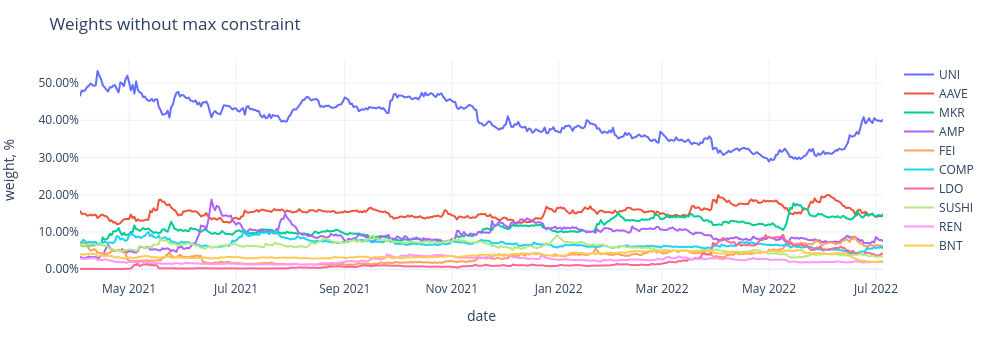

In [48]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

### Adjust weights

This process adjusts weights to adhere to the weight constraints described in our methodology. In addition the `remove_tiny_weights` function checks for any assets with a weight below the minimum threshold of $0.5\%$ and proportionally increases all remaining weights (which are $> 0.5\%$). Note that after this procedure readjusting weights to respect maximum may be needed.

In [49]:
def adjust_weights(weights, max_weight):
    w = weights.copy()
    
    while (w > max_weight).any(axis=None):
        w[w > max_weight] = max_weight
        c = 1 - w.sum(axis=1)
        w_less = w[w < max_weight]
        w[(w < max_weight) & (w > 0)] += w_less.div(w_less.sum(axis=1), axis=0).mul(c, axis=0)
    
    return w

In [50]:
def remove_tiny_weights(weights, min_weight):
    w = weights.copy()
    
    w[w < min_weight] = 0
    w = w.div(w.sum(axis=1), axis=0)
    
    return w

In [51]:
adjusted_weights = adjust_weights(weights, max_weight=0.3) 
adjusted_weights = remove_tiny_weights(adjusted_weights, min_weight=0.005)
adjusted_weights = adjust_weights(adjusted_weights, max_weight=0.3)

adjusted_weights = adjusted_weights.sort_values(adjusted_weights.last_valid_index(),ascending=False, axis = 1)
adjusted_weights

,UNI,AAVE,MKR,AMP,FEI,COMP,LDO,SUSHI,REN,BNT
date,,,,,,,,,,
2021-04-03,0.3,0.205180,0.088079,0.043784,0.088526,0.093046,0.000000,0.089753,0.038312,0.053320
2021-04-04,0.3,0.200194,0.085333,0.042246,0.095067,0.097926,0.000000,0.087639,0.037755,0.053839
2021-04-05,0.3,0.200341,0.082841,0.039674,0.095351,0.106082,0.000000,0.085284,0.037887,0.052540
2021-04-06,0.3,0.200716,0.085604,0.041433,0.093501,0.101080,0.000000,0.086037,0.037251,0.054378
2021-04-07,0.3,0.197361,0.085033,0.042871,0.092381,0.096820,0.000000,0.090787,0.039344,0.055402
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.3,0.163811,0.164752,0.101180,0.075958,0.066230,0.042714,0.038975,0.023153,0.023227
2022-07-02,0.3,0.164886,0.168411,0.094820,0.074705,0.068252,0.043536,0.039363,0.023473,0.022553
2022-07-03,0.3,0.166812,0.169735,0.090867,0.074290,0.067295,0.044453,0.039241,0.024306,0.023000


/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



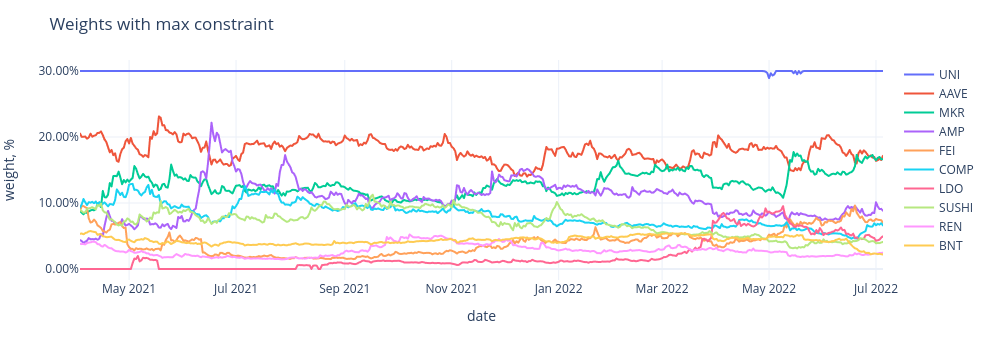

In [52]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

### Convert weights to the [1, 255] scale

On the contract side weights are integer numbers from the interval $[1, 255]$ with total sum $255$, so it's needed to convert retrieved weights to this format.

Note that one can't just round weights to integers after scaling, since it doesn't guarantee that their sum will be $255$. To fix that firstly floor function is applied to the weights and then $1$ is being added to the $k$ weights with largest fractional parts.

In [53]:
def convert_weights(weights):
    w_scaled = weights * 255
    w_res = np.floor(w_scaled).astype(int)    
    remainders = w_scaled - w_res    
    k = round(remainders.sum())
    w_below_max = w_res[w_res<76]
    for i in range(k):
        w_below_max[i] +=1
    for i in w_below_max.index:
        w_res[i] = w_below_max[i]
    return w_res

In [54]:
last_weights = adjusted_weights.iloc[-1].dropna()
last_weights

UNI      0.300000
AAVE     0.171505
MKR      0.166319
AMP      0.088256
FEI      0.070416
COMP     0.065993
LDO      0.049578
SUSHI    0.041114
REN      0.024829
BNT      0.021990
Name: 2022-07-05 00:00:00, dtype: float64

In [55]:
converted_last_weights = convert_weights(last_weights)
converted_last_weights

UNI      76
AAVE     44
MKR      43
AMP      23
FEI      18
COMP     17
LDO      13
SUSHI    10
REN       6
BNT       5
Name: 2022-07-05 00:00:00, dtype: int64

## Summary table

In [56]:
pdi = pd.DataFrame()
pdi.index = chosen_tokens.index
pdi['name'] = chosen_tokens['name']
pdi['market_cap'] = marketcaps.iloc[-1].astype(int)
pdi['price'] = prices_data.iloc[-1]
pdi['weight'] = last_weights
pdi['weight_converted'] = converted_last_weights
pdi['address'] = [top_defi_tokens[symb]['address'] for symb in pdi.index]

pdi = pdi[pdi['weight'] > 0]
pdi = pdi.sort_values("market_cap",ascending=False)
pdi

,name,market_cap,price,weight,weight_converted,address
symbol,,,,,,
UNI,Uniswap,2399880140,5.273516,0.300000,76,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984
AAVE,Aave,877337238,63.117340,0.171505,44,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9
MKR,Maker,850808253,944.390076,0.166319,43,0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
AMP,Amp,451475975,0.009396,0.088256,23,0xff20817765cb7f73d4bde2e66e067e58d11095c2
FEI,Fei USD,360216107,0.999686,0.070416,18,0x956f47f50a910163d8bf957cf5846d573e7f87ca
COMP,Compound,337590541,49.304581,0.065993,17,0xc00e94cb662c3520282e6f5717214004a7f26888
LDO,Lido DAO,253616718,0.543840,0.049578,13,0x5a98fcbea516cf06857215779fd812ca3bef1b32
SUSHI,Sushi,210321478,1.094157,0.041114,10,0x6b3595068778dd592e39a122f4f5a5cf09c90fe2
REN,REN,127013527,0.127185,0.024829,6,0x408e41876cccdc0f92210600ef50372656052a38
